In [22]:
!pip install wandb

   ---------------------------------------- 0.0/20.8 MB ? eta -:--:--
   - -------------------------------------- 0.8/20.8 MB 4.8 MB/s eta 0:00:05
   ------------ --------------------------- 6.3/20.8 MB 18.4 MB/s eta 0:00:01
   -------------- ------------------------- 7.3/20.8 MB 15.1 MB/s eta 0:00:01
   -------------- ------------------------- 7.3/20.8 MB 15.1 MB/s eta 0:00:01
   -------------- ------------------------- 7.3/20.8 MB 15.1 MB/s eta 0:00:01
   -------------- ------------------------- 7.6/20.8 MB 7.0 MB/s eta 0:00:02
   ---------------------- ----------------- 11.5/20.8 MB 8.3 MB/s eta 0:00:02
   ---------------------- ----------------- 11.5/20.8 MB 8.3 MB/s eta 0:00:02
   ------------------------------- -------- 16.3/20.8 MB 9.0 MB/s eta 0:00:01
   ---------------------------------- ----- 17.8/20.8 MB 8.7 MB/s eta 0:00:01
   ------------------------------------ --- 19.1/20.8 MB 8.6 MB/s eta 0:00:01
   ---------------------------------------  20.7/20.8 MB 8.4 MB/s eta 0:00

In [1]:
import wandb
# key = 2d9dcc9f17ad2e9e15adcc2c7cc37c074dbf6645

In [18]:
from tsfm_public.models.tinytimemixer.configuration_tinytimemixer import TinyTimeMixerConfig

In [2]:
wandb.login()

wandb: Currently logged in as: heba-yasin-hdaib (heba-yasin-hdaib-princess-sumaya-university-for-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
import os
os.environ["WANDB_API_KEY"] = "your_api_key_here"

In [2]:
! pip install "granite-tsfm[notebooks]==0.2.23"

In [4]:
!pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 2.6 MB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 2.7 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 2.7 MB/s eta 0:00:00


In [5]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from tsfm_public.toolkit.visualization import plot_predictions

In [6]:
import joblib

In [31]:
# prompt: create output directory
station = 'amman'
output_directory =f'TTM Model/{station.replace(" ", "_")}'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

print(f"Output directory created at: {output_directory}")

Output directory created at: TTM Model/amman


In [33]:
TTM_MODEL_REVISION = "512-96-ft-r2.1"
context_length = 512  # the max context length for the 512-96 model
prediction_length = 96  # the max prediction length for the 512-96 model

# Output directory for writing evaluation results.
OUT_DIR = f"{output_directory}/eval"

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
print(device)

cuda


In [35]:
DATA_FILE_PATH = "Datasets-Ready/amman_Ready.csv"
# DATA_FILE_PATH = 'Datasets-Ready/amman_Ready.csv'
timestamp_column = "Unnamed: 0"
target_columns = ["Air Dew Point",	"Air Temperature (OC)",	"Humidity %",	"Atmospheric Pressure",	"Wind_U",	"Wind_V"]

input_df = pd.read_csv(DATA_FILE_PATH, parse_dates=[timestamp_column])
input_df = input_df.ffill()
input_df.tail()


,Unnamed: 0,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Liquid Precipitation,Cloud Cover %,Wind_U,Wind_V
210379,2023-12-31 19:00:00,7.4556,10.0,85.3540,1021.9222,0.0,17.2325,-1.0833,-2.4689
210380,2023-12-31 20:00:00,7.3111,9.0,88.6544,1022.1000,0.0,17.2325,-0.8378,-2.4933
210381,2023-12-31 21:00:00,7.0556,8.2,91.3817,1022.1000,0.0,17.2325,-0.3844,-2.3767
210382,2023-12-31 22:00:00,6.9444,8.0,93.4185,1022.1000,0.0,17.2325,0.1367,-2.2989
210383,2023-12-31 23:00:00,6.9444,7.0,93.4185,1022.1000,0.0,17.2325,0.1367,-2.2989


In [36]:
for col in input_df.columns:
    input_df[col] = round(input_df[col], 2)

In [37]:
# context_length = len(input_df)
# input_df = input_df.iloc[-context_length:,]

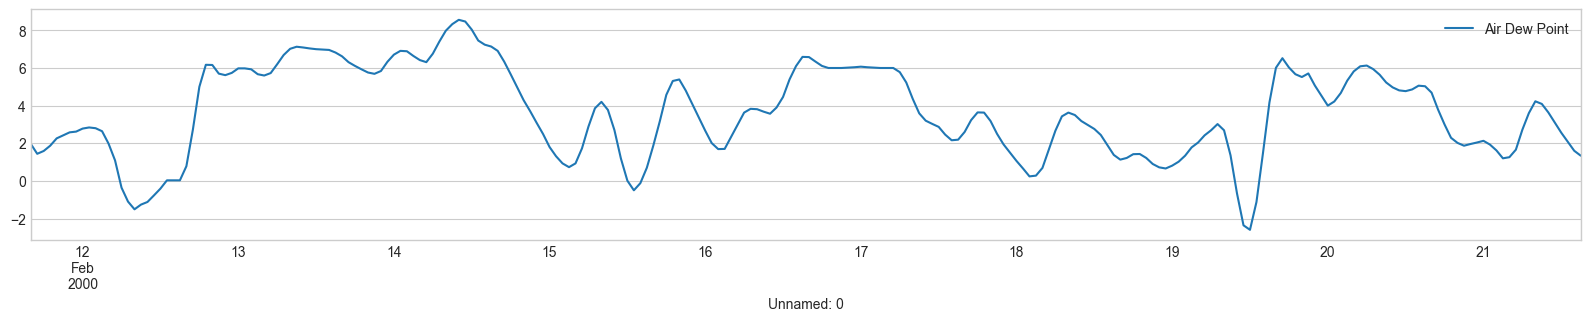

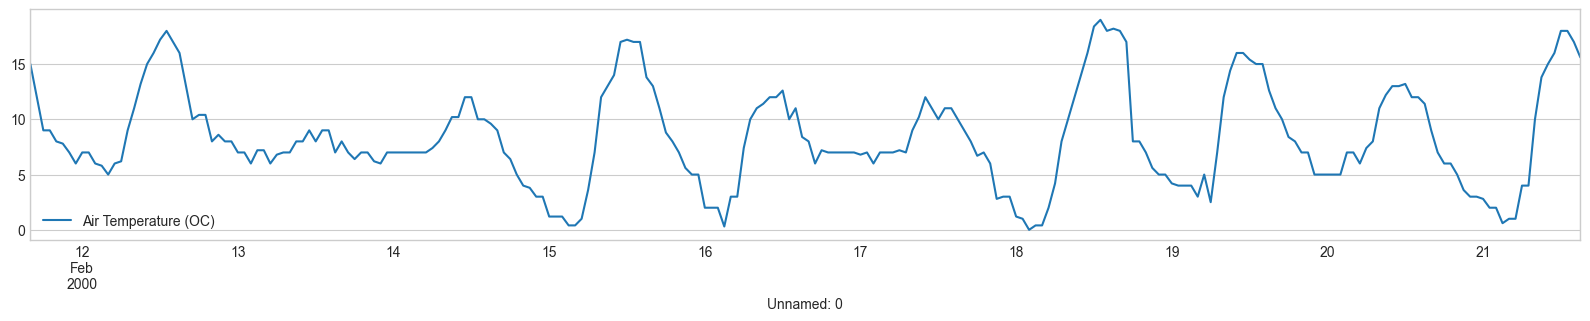

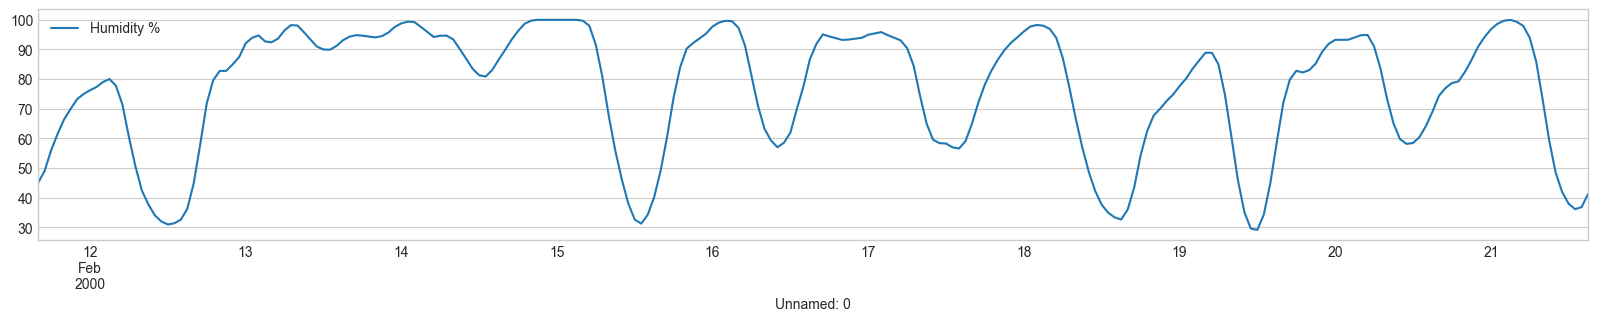

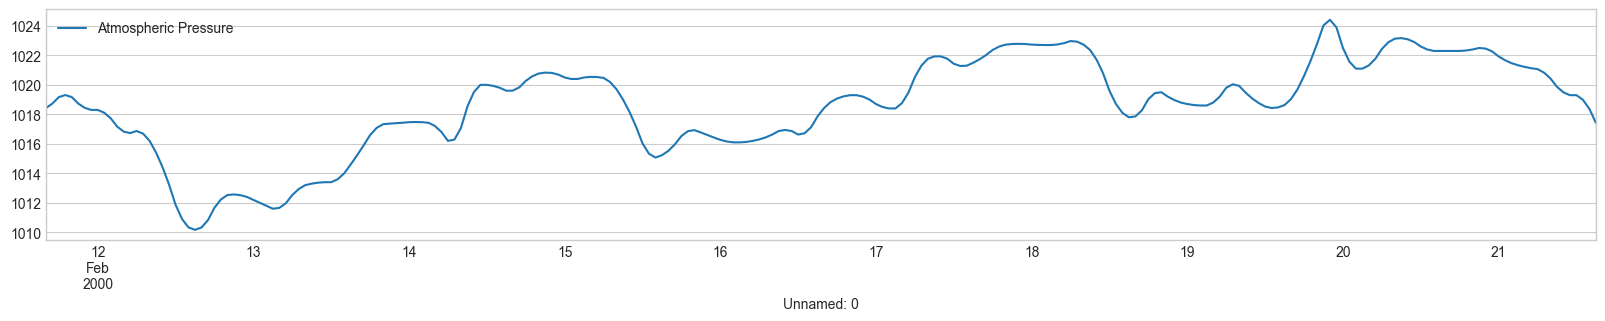

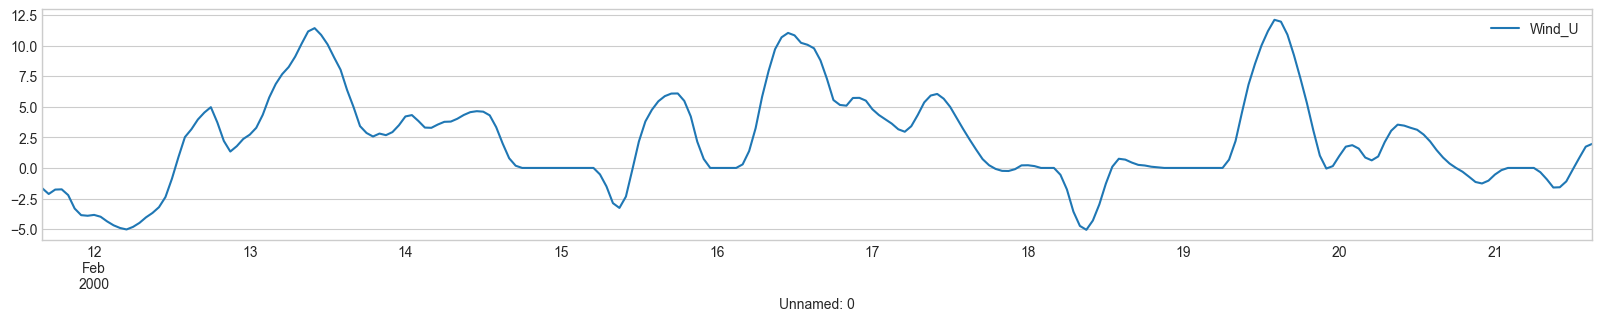

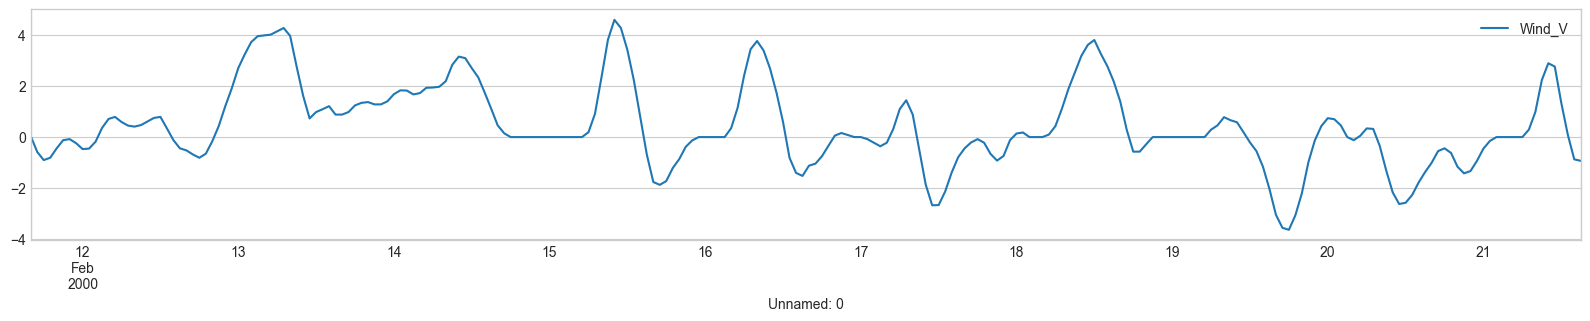

In [38]:
for target_column in target_columns:
    input_df.iloc[1000 : 1000 + 24 * 10].plot(x=timestamp_column, y=target_column, figsize=(20, 3))

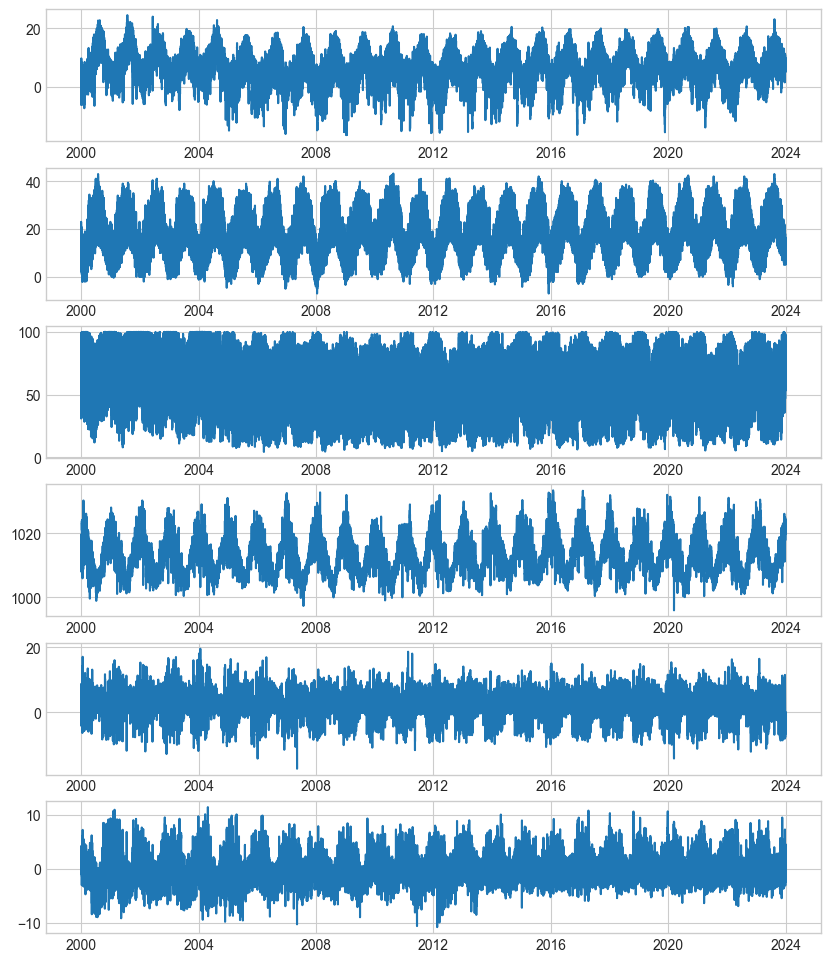

In [39]:
fig, axs = plt.subplots(len(target_columns), 1, figsize=(10, 2 * len(target_columns)), squeeze=False)
for ax, target_column in zip(axs, target_columns):
    ax[0].plot(input_df[timestamp_column], input_df[target_column])

In [40]:
split_config = {"train": 0.75, "test": 0.1}

train_df, valid_df, test_df = prepare_data_splits(input_df, context_length=context_length, split_config=split_config)
print(f"Data lengths: train = {len(train_df)}, val = {len(valid_df)}, test = {len(test_df)}")

Data lengths: train = 105192, val = 53108, test = 53108


In [41]:
tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=prediction_length,
    scaling=True,
    scaler_type="standard",
)

trained_tsp = tsp.train(train_df)

In [15]:
# zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
#     "ibm-granite/granite-timeseries-ttm-r2",  # Name of the model on HuggingFace.
#     revision=TTM_MODEL_REVISION,
#     num_input_channels=len(target_columns),  # Number of input columns.
# )

In [16]:
# pipeline = TimeSeriesForecastingPipeline(
#     zeroshot_model,
#     device=device,  # Specify your local GPU or CPU.
#     feature_extractor=tsp,
#     batch_size=512,
# )

# # Make a forecast on the target column given the input data.
# zeroshot_forecast = pipeline(test_df)
# zeroshot_forecast.head()

Device set to use cuda


,Unnamed: 0,Air Dew Point_prediction,Air Temperature (OC)_prediction,Humidity %_prediction,Atmospheric Pressure_prediction,Wind_U_prediction,Wind_V_prediction,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Wind_U,Wind_V
0,2017-12-31 11:00:00,"[6.059651917661656, 5.692611627585116, 5.78791...","[14.555286910510253, 14.944826831804914, 14.48...","[56.58124871989871, 55.82506180211265, 57.9136...","[1017.7270412775354, 1017.6274958893914, 1017....","[3.1205062461371513, 2.58488035106118, 2.25552...","[1.4490018670333664, 1.134518401535121, 0.6362...","[5.600000011611753, 3.9999999837259668, 2.0000...","[12.999999878048792, 12.000000064161446, 12.00...","[60.78000009746849, 58.04999993578658, 50.3900...","[1015.499999928869, 1015.499999928869, 1015.49...","[5.609999942654334, 9.299999764453528, 5.09999...","[0.990000017921035, 6.731917134850107e-09, 6.7..."
1,2017-12-31 12:00:00,"[5.687227593998379, 5.579088606900399, 5.18127...","[14.288250241683118, 14.05402283104992, 13.056...","[54.9418601827673, 56.670611292009944, 59.7581...","[1016.5624333098162, 1016.9712355546046, 1017....","[3.6652712587381924, 3.009284438361922, 2.5546...","[0.8505825493115508, 0.39075279955611486, -0.0...","[3.9999999837259668, 2.0000000840915995, 2.300...","[12.000000064161446, 12.000000064161446, 10.79...","[58.04999993578658, 50.39000009234715, 55.7300...","[1015.499999928869, 1015.499999928869, 1016.20...","[9.299999764453528, 5.09999996389504, 2.679999...","[6.731917134850107e-09, 6.731917134850107e-09,..."
2,2017-12-31 13:00:00,"[4.750776440853093, 4.356047556376236, 4.13820...","[12.986494751350783, 12.339222102426552, 11.40...","[55.60747776227922, 58.48553707500812, 62.2314...","[1016.64925209255, 1017.191732018658, 1017.595...","[5.475214162529616, 4.292951677321138, 3.26822...","[0.13111091168367206, -0.18676906421430817, -0...","[2.0000000840915995, 2.3000001231259004, 2.000...","[12.000000064161446, 10.799999866325152, 8.999...","[50.39000009234715, 55.73000004247357, 61.5399...","[1015.499999928869, 1016.2000001601673, 1016.2...","[5.09999996389504, 2.679999968655218, 3.549999...","[6.731917134850107e-09, 1.549999957816862, 2.0..."
3,2017-12-31 14:00:00,"[2.902162324654825, 2.7132678820760874, 2.9358...","[12.018722189320187, 11.284354437378374, 10.74...","[52.84561985260985, 56.895770938237995, 61.113...","[1016.752973408881, 1017.1973921997135, 1017.6...","[3.9813618087369305, 2.998185702975172, 2.3704...","[-0.12959676344024135, -0.3028718529976627, -0...","[2.3000001231259004, 2.0000000840915995, 2.000...","[10.799999866325152, 8.999999832802883, 7.9999...","[55.73000004247357, 61.539999898391834, 65.850...","[1016.2000001601673, 1016.2000001601673, 1016....","[2.679999968655218, 3.549999963068643, -0.4500...","[1.549999957816862, 2.0500001202506875, -2.560..."
4,2017-12-31 15:00:00,"[2.946976263847941, 3.0756038588331873, 2.9621...","[10.731678481972455, 10.284677082904437, 9.899...","[59.71730555821996, 63.46264237599712, 66.7523...","[1017.1708472000969, 1017.6261196763246, 1018....","[2.3799188692919464, 1.9098898431433828, 1.620...","[0.3010020034007287, -0.09503230620483932, -0....","[2.0000000840915995, 2.0000000840915995, 2.300...","[8.999999832802883, 7.999999755683364, 5.80000...","[61.539999898391834, 65.8500000316044, 78.2299...","[1016.2000001601673, 1016.2000001601673, 1017....","[3.549999963068643, -0.4500000256186085, -0.45...","[2.0500001202506875, -2.560000056746912, -2.56..."


In [42]:
def custom_metric(actual, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())

    mask = ~np.any(np.isnan(a), axis=1)

    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    mae = np.mean(np.abs(a[mask, :] - p[mask, :]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )

for target_column in target_columns:
  print(custom_metric(zeroshot_forecast[target_column], zeroshot_forecast[target_column+'_prediction'], target_column))


                         Air Dew Point
mean_squared_error           13.009846
root_mean_squared_error       3.606916
mean_absolute_error           2.765452
                         Air Temperature (OC)
mean_squared_error                  11.249600
root_mean_squared_error              3.354042
mean_absolute_error                  2.520945
                         Humidity %
mean_squared_error       255.055944
root_mean_squared_error   15.970471
mean_absolute_error       12.479894
                         Atmospheric Pressure
mean_squared_error                  11.318441
root_mean_squared_error              3.364289
mean_absolute_error                  2.491138
                            Wind_U
mean_squared_error       10.813941
root_mean_squared_error   3.288456
mean_absolute_error       2.400973
                           Wind_V
mean_squared_error       3.607077
root_mean_squared_error  1.899231
mean_absolute_error      1.397625


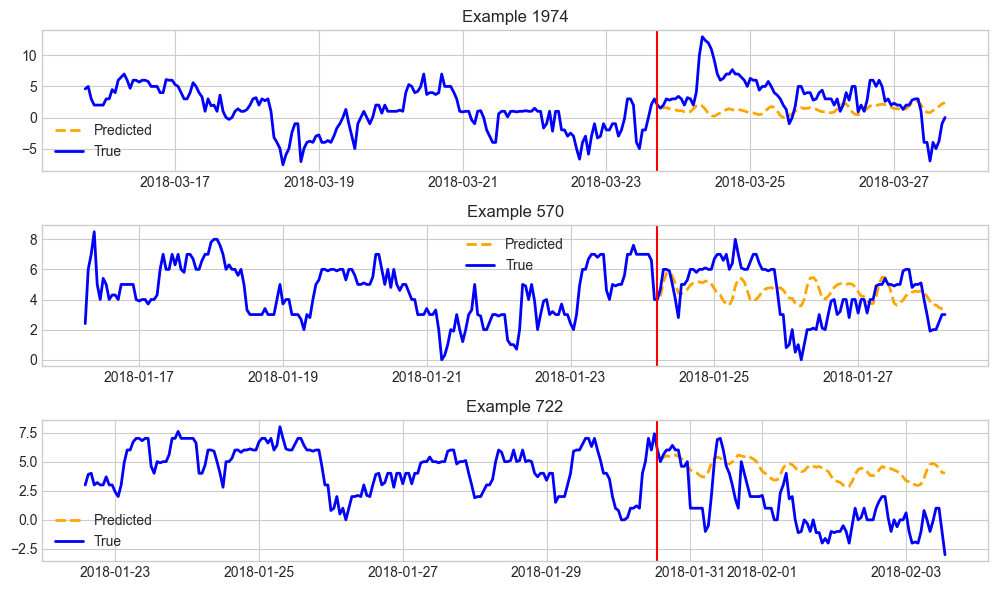

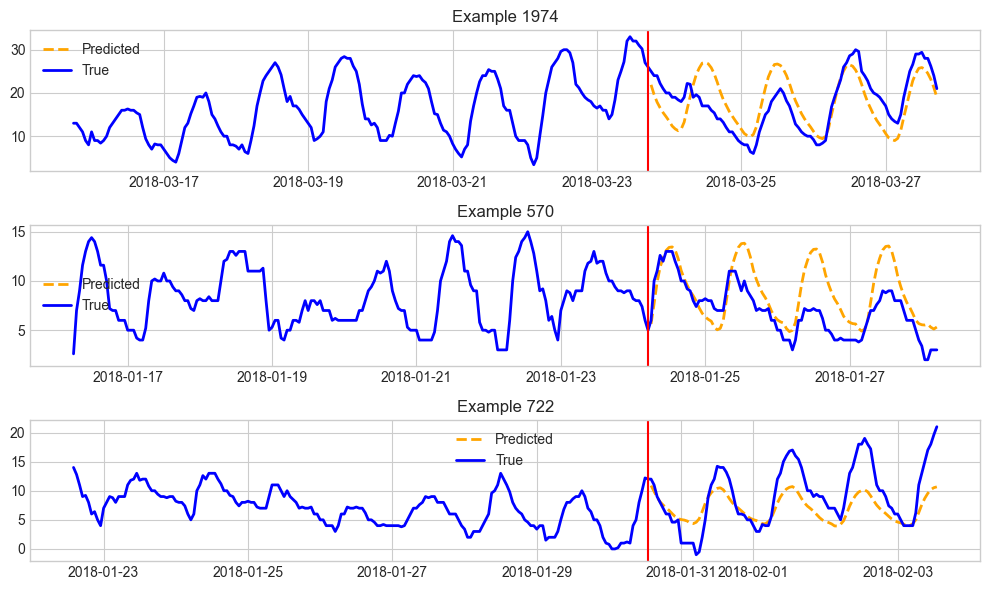

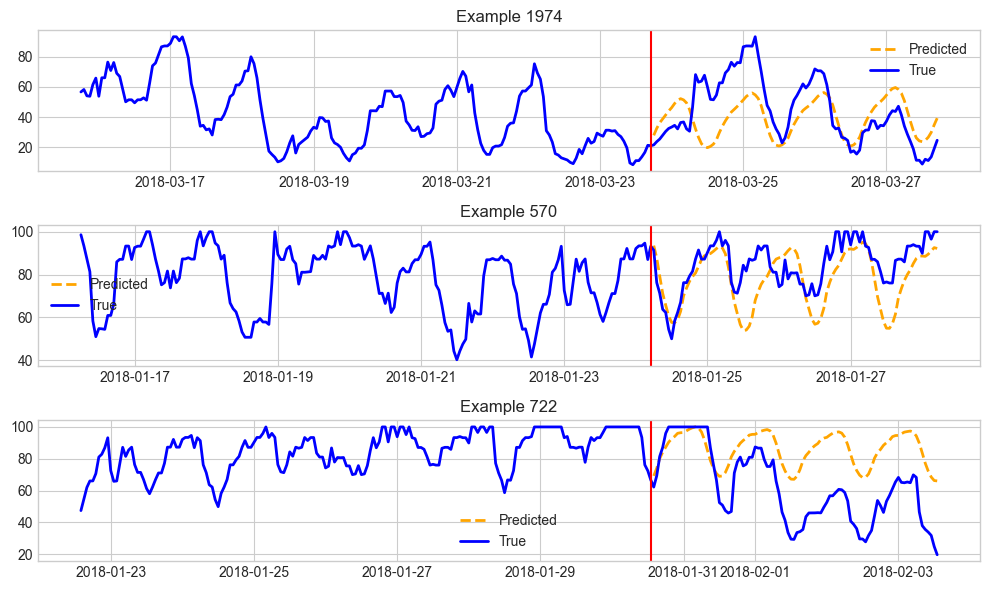

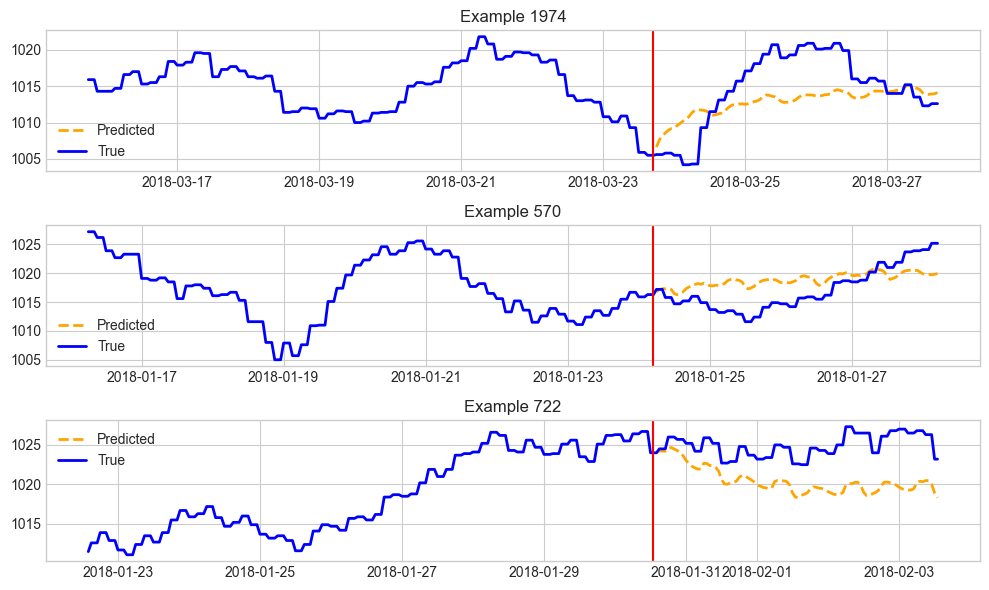

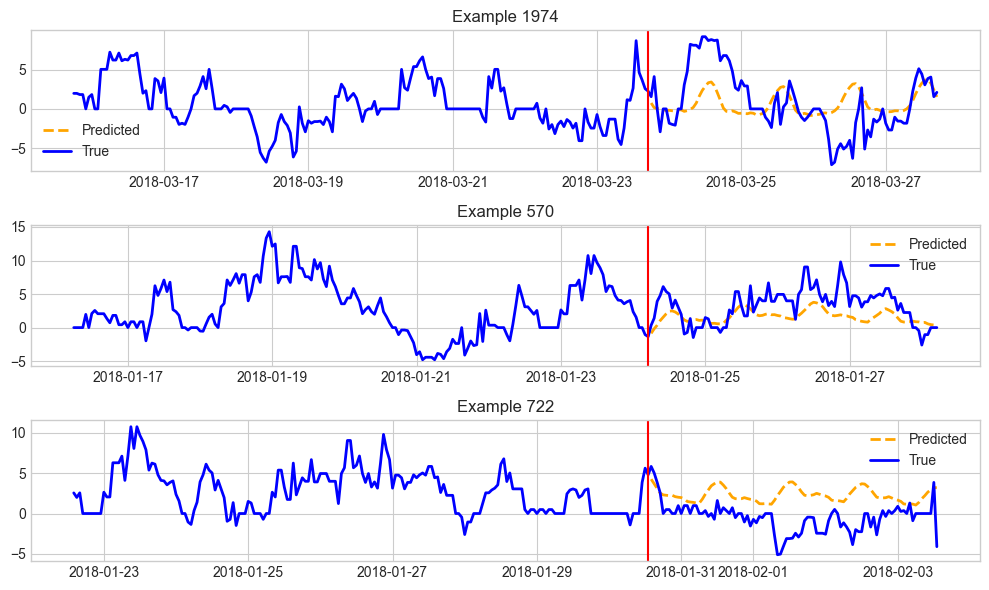

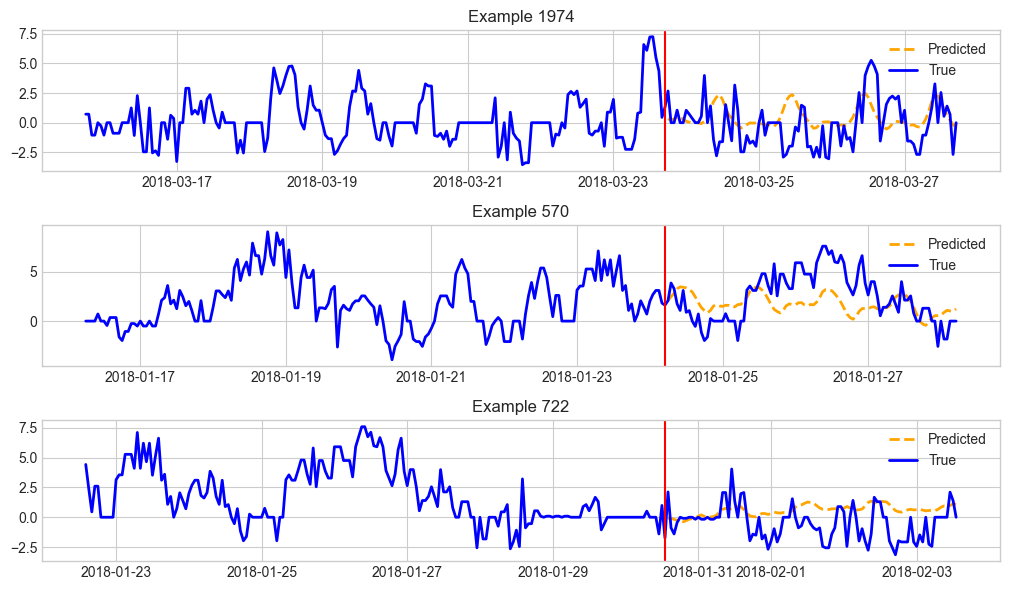

In [18]:
for target_column in target_columns:
  plot_predictions(
    input_df=test_df,
    predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[1974, 570, 722],
  )

fine tuning

In [43]:
target_columns = ["Air Dew Point",	"Air Temperature (OC)",	"Humidity %",	"Atmospheric Pressure",	"Wind_U",	"Wind_V"]

In [44]:
SEED = 42
set_seed(SEED)

# control_columns = ["Air Dew Point",	"Air Temperature (OC)",	"Humidity %",	"Atmospheric Pressure",	"Wind_U",	"Wind_V"]
control_columns = []

tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    target_columns=target_columns,
    control_columns=control_columns,
    context_length=context_length,
    prediction_length=prediction_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

In [45]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",
    revision=TTM_MODEL_REVISION,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # exog:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_context_length=1,  # exog: indicates lag length to use in the exog fusion. for Ex. if today sales can get affected by discount on +/- 2 days, mention 2
    fcm_use_mixer=True,  # exog: Try true (1st option) or false
    fcm_mix_layers=2,  # exog: Number of layers for exog mixing
    enable_forecast_channel_mixing=True,  # exog: set true for exog mixing
    fcm_prepend_past=True,  # exog: set true to include lag from history during exog infusion.
)

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

In [46]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 858462
Number of params after freezing the backbone 305524


In [23]:
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, input_df, split_config, use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 104585, val = 52501, test = 52501


In [47]:
# Important parameters
learning_rate = 0.00029836  # 0.000298364724028334
num_epochs = 50  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=4,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    use_cpu=device != "cuda",  # Remove when GPU is available
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

Using learning rate = 0.00029836


In [48]:
finetune_forecast_trainer.train()


Epoch,Training Loss,Validation Loss
1,0.788800,0.482093
2,0.529300,0.473922
3,0.496800,0.467425
4,0.477200,0.459814
5,0.466700,0.456299
6,0.459800,0.452359
7,0.453800,0.448468
8,0.448900,0.446692
9,0.444600,0.444688
10,0.440800,0.445644


[TrackingCallback] Mean Epoch Time = 55.8282505963978 seconds, Total Train Time = 1675.8411674499512


TrainOutput(global_step=31065, training_loss=0.4644939604961371, metrics={'train_runtime': 1675.8474, 'train_samples_per_second': 3120.362, 'train_steps_per_second': 48.781, 'total_flos': 3.141902063978496e+16, 'train_loss': 0.4644939604961371, 'epoch': 19.0})

In [56]:
pipeline = TimeSeriesForecastingPipeline(
    finetune_forecast_model,
    device=device,  # Specify your local GPU or CPU.
    feature_extractor=tsp,
    batch_size=batch_size,
)

# Make a forecast on the target column given the input data.
finetune_forecast = pipeline(test_df)
finetune_forecast.head()

AttributeError: 'NoneType' object has no attribute 'freqstr'

In [57]:
for target_column in target_columns:
  print(custom_metric(zeroshot_forecast[target_column], zeroshot_forecast[target_column+'_prediction'], target_column))


                         Air Dew Point
mean_squared_error           13.009846
root_mean_squared_error       3.606916
mean_absolute_error           2.765452
                         Air Temperature (OC)
mean_squared_error                  11.249600
root_mean_squared_error              3.354042
mean_absolute_error                  2.520945
                         Humidity %
mean_squared_error       255.055944
root_mean_squared_error   15.970471
mean_absolute_error       12.479894
                         Atmospheric Pressure
mean_squared_error                  11.318441
root_mean_squared_error              3.364289
mean_absolute_error                  2.491138
                            Wind_U
mean_squared_error       10.813941
root_mean_squared_error   3.288456
mean_absolute_error       2.400973
                           Wind_V
mean_squared_error       3.607077
root_mean_squared_error  1.899231
mean_absolute_error      1.397625


In [ ]:
# plot
for target_column in target_columns:
  plot_predictions(
      input_df=test_df,
      predictions_df=finetune_forecast,
      freq="h",
      timestamp_column=timestamp_column,
      channel=target_column,
      indices=[3532],
  )

In [50]:
#Saving
save_path = os.path.join(OUT_DIR, "finetuned_model")

# Save model and tokenizer 
finetune_forecast_model.save_pretrained(save_path)
tsp.save_pretrained(save_path)

print(f"Model and preprocessor saved to {save_path}")

Model and preprocessor saved to TTM Model/amman/eval\finetuned_model


In [55]:
import joblib
preprocessor_path = f"{OUT_DIR}/trained_preprocessor.joblib"
# Save preprocessor to disk
joblib.dump(trained_tsp, preprocessor_path)

['TTM Model/amman/eval/trained_preprocessor.joblib']

In [52]:
preprocessor_path

'TTM Model/amman/eval/trained_preprocessor.joblib'

# Training All Stations

In [7]:
aqaba = pd.read_csv('Datasets-Ready/aqaba_Ready.csv')
ghor = pd.read_csv('Datasets-Ready/ghor_Ready.csv')
irbid = pd.read_csv('Datasets-Ready/irbid_Ready.csv')
irwaished = pd.read_csv('Datasets-Ready/irwaished_Ready.csv')
maan = pd.read_csv('Datasets-Ready/maan_Ready.csv')
mafraq = pd.read_csv('Datasets-Ready/mafraq_Ready.csv')
amman = pd.read_csv('Datasets-Ready/amman_Ready.csv')  
safawi = pd.read_csv('Datasets-Ready/safawi_Ready.csv')

In [8]:
names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq','amman', 'safawi']
datasets = [aqaba, ghor, irbid, irwaished, maan, mafraq, amman, safawi]
coordinates = [            # (latitude, longitude)
    (29.5500, 35.0000),    # Aqabah
    (31.0333, 35.4667),    # Ghor
    (32.5500, 35.8500),    # Irbid
    (32.5000, 38.2000),    # Irwaished
    (30.1667, 35.7833),    # Maan
    (32.3667, 36.2500),    # Mafraq
    (31.7167, 35.9833),    # Amman
    (32.1608, 37.1539),    # Safawi
]
Stations = {}
for i in range(len(names)):
    Stations[names[i]] = {}
    Stations[names[i]]['coordinates'] = coordinates[i]
    Stations[names[i]]['dataset'] = datasets[i]

In [25]:
TTM_MODEL_REVISION = "512-96-ft-r2.1"
context_length = 512  # the max context length for the 512-96 model
prediction_length = 96  # the max prediction length for the 512-96 model

# Output directory for writing evaluation results.


# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
def custom_metric(actual, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())

    mask = ~np.any(np.isnan(a), axis=1)

    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    mae = np.mean(np.abs(a[mask, :] - p[mask, :]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )


In [ ]:
for i in range(len(names)):

    station = names[i]
    output_directory =f'TTM Model/{station.replace(" ", "_")}'
    if not os.path.exists(output_directory):
      os.makedirs(output_directory)

    print(f"Output directory created at: {output_directory}")
    OUT_DIR = f"{output_directory}/eval"
    DATA_FILE_PATH = f"Datasets-Ready/{station.replace(' ', '_')}_Ready.csv"
    # DATA_FILE_PATH = 'Datasets-Ready/amman_Ready.csv'
    timestamp_column = "Unnamed: 0"
    target_columns = ["Air Dew Point",	"Air Temperature (OC)",	"Humidity %",	"Atmospheric Pressure",	"Wind_U",	"Wind_V"]

    input_df = pd.read_csv(DATA_FILE_PATH, parse_dates=[timestamp_column])
    input_df = input_df.ffill()
    split_config = {"train": 0.75, "test": 0.1}
    control_columns = []

    tsp = TimeSeriesPreprocessor(
        timestamp_column=timestamp_column,
        target_columns=target_columns,
        control_columns=control_columns,
        context_length=context_length,
        prediction_length=prediction_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    preprocessor_path = f"{OUT_DIR}/trained_preprocessor.joblib"
    train_size = int(len(input_df) * split_config["train"])
    train_df = input_df[:train_size]
    trained_tsp = tsp.train(train_df)
    

    SEED = 42
    set_seed(SEED)

    # control_columns = ["Air Dew Point",	"Air Temperature (OC)",	"Humidity %",	"Atmospheric Pressure",	"Wind_U",	"Wind_V"]
    

    

    finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",
    revision=TTM_MODEL_REVISION,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # exog:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_context_length=1,  # exog: indicates lag length to use in the exog fusion. for Ex. if today sales can get affected by discount on +/- 2 days, mention 2
    fcm_use_mixer=True,  # exog: Try true (1st option) or false
    fcm_mix_layers=2,  # exog: Number of layers for exog mixing
    enable_forecast_channel_mixing=True,  # exog: set true for exog mixing
    fcm_prepend_past=True,  # exog: set true to include lag from history during exog infusion.
    )

    print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
    )

    # Freeze the backbone of the model
    for param in finetune_forecast_model.backbone.parameters():
        param.requires_grad = False

    # Count params
    print(
        "Number of params after freezing the backbone",
        count_parameters(finetune_forecast_model),
    )
    train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, input_df, split_config, use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning
    )
    print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

    learning_rate = 0.00029836  # 0.000298364724028334
    num_epochs = 50  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
    batch_size = 64

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(OUT_DIR, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=4,
        report_to=None,
        weight_decay=0.01,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        use_cpu=device != "cuda",  # Remove when GPU is available
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    finetune_forecast_trainer.train()

    save_path = os.path.join(OUT_DIR, "finetuned_model")

    # Save model and tokenizer 
    finetune_forecast_model.save_pretrained(save_path)
    joblib.dump(trained_tsp, preprocessor_path)
 

Output directory created at: TTM Model/aqaba


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Number of params before freezing backbone 858462
Number of params after freezing the backbone 305524
Data lengths: train = 157181, val = 31463, test = 20943
Using learning rate = 0.00029836


Epoch,Training Loss,Validation Loss
1,0.625800,0.420177
2,0.456900,0.413048
3,0.432800,0.407943
4,0.422000,0.404442
5,0.416700,0.402061
6,0.413200,0.400254
7,0.410100,0.397338
8,0.407100,0.394980
9,0.404300,0.394817
10,0.401900,0.393668


[TrackingCallback] Mean Epoch Time = 68.30268793106079 seconds, Total Train Time = 1959.0766954421997
Output directory created at: TTM Model/ghor


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Number of params before freezing backbone 858462
Number of params after freezing the backbone 305524
Data lengths: train = 157179, val = 31463, test = 20943
Using learning rate = 0.00029836


Epoch,Training Loss,Validation Loss
1,0.710900,0.803007
2,0.523500,0.790867
3,0.497600,0.785096
4,0.486000,0.782795
5,0.479400,0.782599
6,0.474800,0.781971
7,0.471300,0.781321
8,0.468700,0.781217
9,0.466500,0.783671
10,0.464600,0.784115


[TrackingCallback] Mean Epoch Time = 67.3682464228736 seconds, Total Train Time = 1746.2716748714447
Output directory created at: TTM Model/irbid


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Number of params before freezing backbone 858462
Number of params after freezing the backbone 305524
Data lengths: train = 157177, val = 31463, test = 20942
Using learning rate = 0.00029836


Epoch,Training Loss,Validation Loss
1,0.704900,0.152588
2,0.522200,0.151302
3,0.496200,0.150463
4,0.482900,0.149792
5,0.475300,0.149799
6,0.470100,0.149658
7,0.466300,0.149826
8,0.462600,0.150377
9,0.459300,0.150937
10,0.456400,0.151334


[TrackingCallback] Mean Epoch Time = 66.61925092339516 seconds, Total Train Time = 1531.4846007823944
Output directory created at: TTM Model/irwaished


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Number of params before freezing backbone 858462
Number of params after freezing the backbone 305524
Data lengths: train = 142930, val = 28613, test = 19043
Using learning rate = 0.00029836


Epoch,Training Loss,Validation Loss
1,0.730800,0.476689
2,0.536200,0.471920
3,0.508800,0.467808
4,0.494500,0.465942
5,0.486500,0.464899
6,0.481200,0.463733
7,0.477400,0.463632
8,0.474700,0.463406
9,0.472100,0.465814
10,0.469700,0.465328


[TrackingCallback] Mean Epoch Time = 63.20733371045854 seconds, Total Train Time = 1664.8834192752838
Output directory created at: TTM Model/maan


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Number of params before freezing backbone 858462
Number of params after freezing the backbone 305524
Data lengths: train = 157177, val = 31463, test = 20942
Using learning rate = 0.00029836


Epoch,Training Loss,Validation Loss
1,0.727300,0.430105
2,0.541900,0.425613
3,0.517000,0.422718
4,0.505700,0.420306
5,0.499600,0.418710
6,0.495400,0.416576
7,0.492200,0.415701
8,0.489000,0.414936
9,0.486400,0.417242
10,0.484300,0.413776


[TrackingCallback] Mean Epoch Time = 67.12437489032746 seconds, Total Train Time = 1927.3854188919067
Output directory created at: TTM Model/mafraq


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Number of params before freezing backbone 858462
Number of params after freezing the backbone 305524
Data lengths: train = 157179, val = 31463, test = 20943
Using learning rate = 0.00029836


Epoch,Training Loss,Validation Loss
1,0.709700,0.477836
2,0.512500,0.470771
3,0.485700,0.464535
4,0.472200,0.460701
5,0.464300,0.457815
6,0.457800,0.455238
7,0.452300,0.453005
8,0.448500,0.451794
9,0.445600,0.449305
10,0.443200,0.450082


[TrackingCallback] Mean Epoch Time = 66.77814363178454 seconds, Total Train Time = 1830.0451126098633
Output directory created at: TTM Model/amman


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Number of params before freezing backbone 858462
Number of params after freezing the backbone 305524
Data lengths: train = 157181, val = 31463, test = 20943
Using learning rate = 0.00029836


Epoch,Training Loss,Validation Loss
1,0.692600,0.469826
2,0.497100,0.460941
3,0.468300,0.452500
4,0.453900,0.447566
5,0.444700,0.441808
6,0.437200,0.438517
7,0.431900,0.436411
8,0.427800,0.435416
9,0.424300,0.437807
10,0.420900,0.434913
